# Table of Contents
 <p><div class="lev1"><a href="#Importing-Data"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importing Data</a></div><div class="lev1"><a href="#Time-Series-GP-for-Single-Station"><span class="toc-item-num">2&nbsp;&nbsp;</span>Time Series GP for Single Station</a></div><div class="lev1"><a href="#Spatiotemporal-model-for-2-stations"><span class="toc-item-num">3&nbsp;&nbsp;</span>Spatiotemporal model for 2 stations</a></div><div class="lev2"><a href="#Data-prep"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data prep</a></div><div class="lev2"><a href="#Inference"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Inference</a></div><div class="lev1"><a href="#Imputation-model"><span class="toc-item-num">4&nbsp;&nbsp;</span>Imputation model</a></div>

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# module import
import pystan
import numpy as np
import pandas as pd
import matplotlib
import math
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
plt.rcParams['figure.figsize'] = (8.0, 6.0)

# Importing Data

In [2]:
isdList=pd.read_csv("isdList.csv")
isdList.head()

,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END
0,10010,99999,JAN MAYEN(NOR-NAVY),NO,NaN,ENJA,70.933,-8.667,9.0,1931,2015
1,10060,99999,EDGEOYA,NO,NaN,NaN,78.250,22.817,14.0,1973,2015
2,10070,99999,NY-ALESUND,SV,NaN,NaN,78.917,11.933,7.7,1973,2015
3,10080,99999,LONGYEAR,SV,NaN,ENSB,78.246,15.466,26.8,1975,2015
4,10090,99999,KARL XII OYA,SV,NaN,NaN,80.650,25.000,5.0,1955,2015


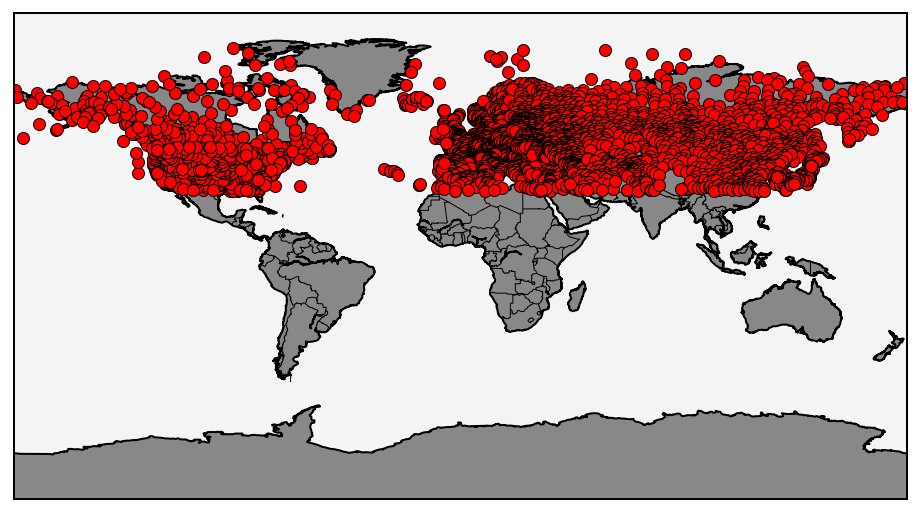

In [3]:
mapplot = Basemap(projection='gall', 
              # with low resolution,
              resolution = 'l', 
              # And threshold 100000
              area_thresh = 100000.0,
              # Centered at 0,0 (i.e null island)
              lat_0=0, lon_0=0)
# Draw the coastlines on the map
mapplot.drawcoastlines()

# Draw country borders on the map
mapplot.drawcountries()

# Fill the land with grey
mapplot.fillcontinents(color = '#888888')

# Draw the map boundaries
mapplot.drawmapboundary(fill_color='#f4f4f4')

# Define our longitude and latitude points
# We have to use .values because of a wierd bug when passing pandas data
# to basemap.
x,y = mapplot(isdList['LON'].values, isdList['LAT'].values)

# Plot them using round markers of size 6
mapplot.plot(x, y, 'ro', markersize=6)

# Show the map
plt.show()              

In [4]:
ma_stations = isdList[isdList["STATE"]=="MA"]
ma_stations[["USAF","WBAN"]]

,USAF,WBAN
4024,725090,14739
4203,744910,14703
4204,744915,14775


In [6]:
isdSubset = isdList[(isdList["USAF"]>714300)&(isdList["USAF"]<714400)]
station_filenames = ["%d.%d.processed.2015.2015.csv" % (r["USAF"],r["WBAN"]) for i,r in isdSubset.iterrows()]
def add_dates(df):
    df_dates = [datetime.datetime(*map(int, r[1][["year","month","day","hour","min","seconds"]])) for r in df.iterrows()]
#     df["datetime"] = df_dates
    temp_series = pd.Series(df["temp"].values, index=pd.DatetimeIndex(df_dates))
#     df.set_index(keys=["datetime"], inplace=True)
#     return df["temp"]
    return temp_series
    
hourly_ls = [pd.read_csv("data2015/"+fn, names=["year", "month", "day", "hour", "min", "seconds","temp"]) 
    for fn in station_filenames]
hourly_ls = list(map(add_dates, hourly_ls))

''

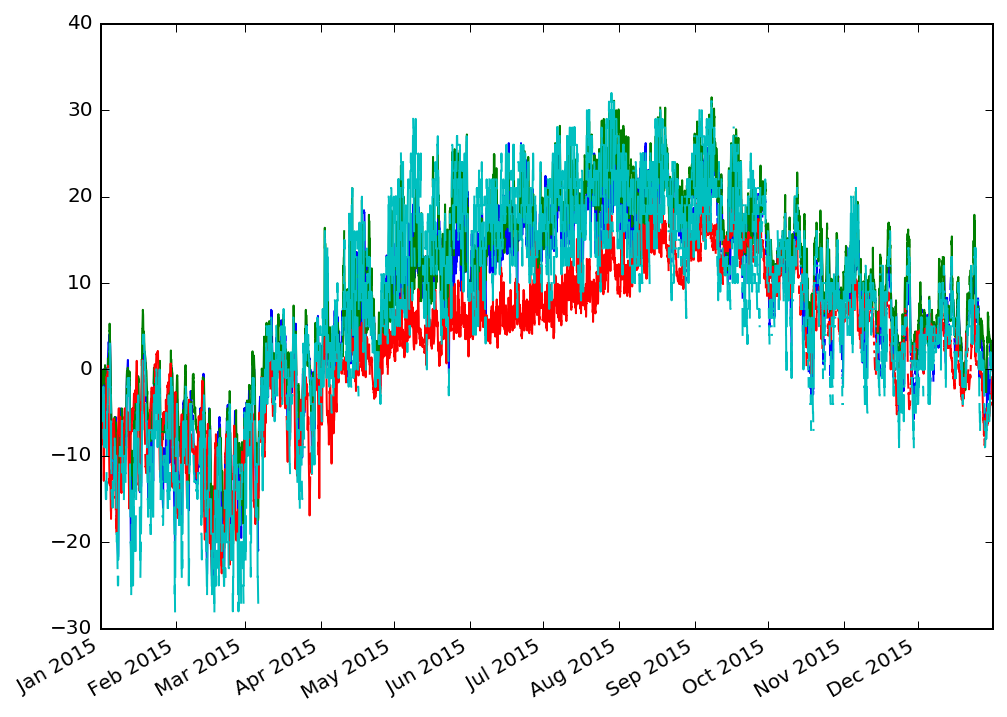

In [7]:
for hourly in hourly_ls:
    plt.plot(hourly)
plt.gcf().autofmt_xdate()
;

''

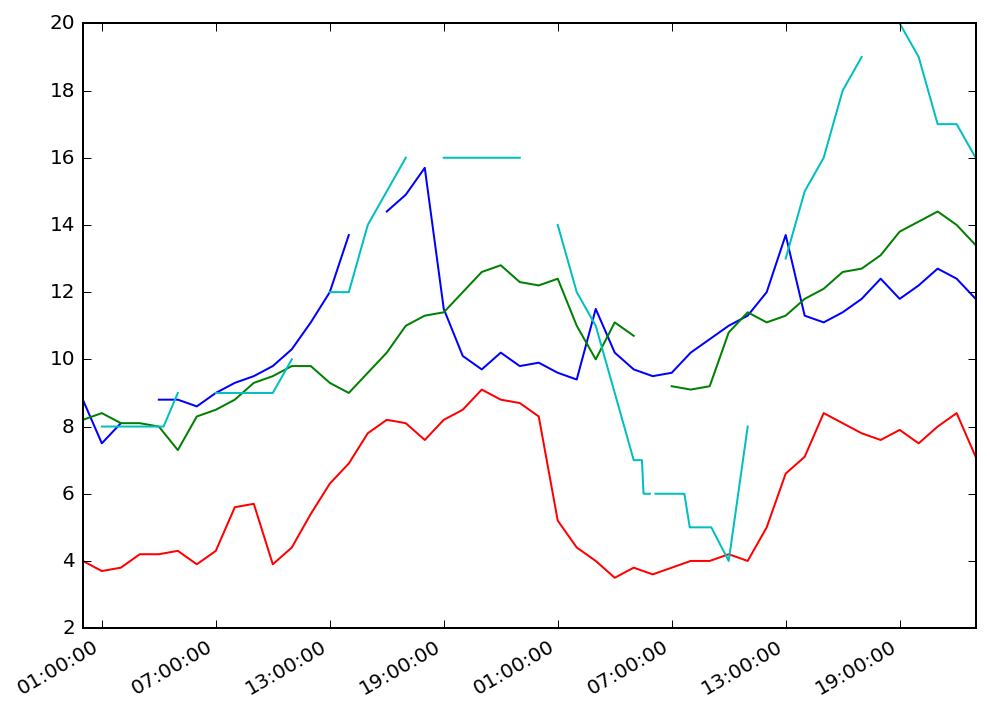

In [8]:
for hourly in hourly_ls:
    plt.plot(hourly["20150601":"20150602"])
plt.gcf().autofmt_xdate()
;

# Time Series GP for Single Station

In [9]:
ns_per_day = 1e9 * 3600 * 24
twodays = hourly["20150601":"20150602"].dropna()
ts_data = {"time": twodays.index.values.astype(float) / ns_per_day,
         "temp": twodays - twodays.mean(),
         "N": twodays.size,
         }

In [10]:
timeseries_model = """
    data {
      int<lower=1> N;
      vector[N] time;
      vector[N] temp;
    }

    parameters {
      real<lower=0> sigmasq;
      real<lower=0> phi;
      real<lower=0> tausq;

      vector[N] w_s;
    }

    model {
      matrix[N,N] Sigma;
      vector[N] mu_w;
      
      for(i in 1:(N)){
          mu_w[i] <- 0.0;
      }

      // off-diagonal elements
      for(i in 1:(N-1)){
        for(j in (i+1):N){
          Sigma[i,j] <- sigmasq * exp( -pow(time[i] - time[j],2)/pow(phi,2));
          Sigma[j,i] <- Sigma[i,j];
        }
      }

      // diagonal elements
      for(i in 1:N){
        Sigma[i,i] <- sigmasq + 0.001;
      }
      phi ~ normal(0,1);
      sigmasq ~ normal(0,10);
      tausq ~ normal(0,1);

      w_s ~ multi_normal(mu_w, Sigma);  
      temp ~ normal(w_s, tausq);
    }
"""

In [11]:
ts_fit = pystan.stan(model_code=timeseries_model, data=ts_data,
 iter=1000, chains=4)

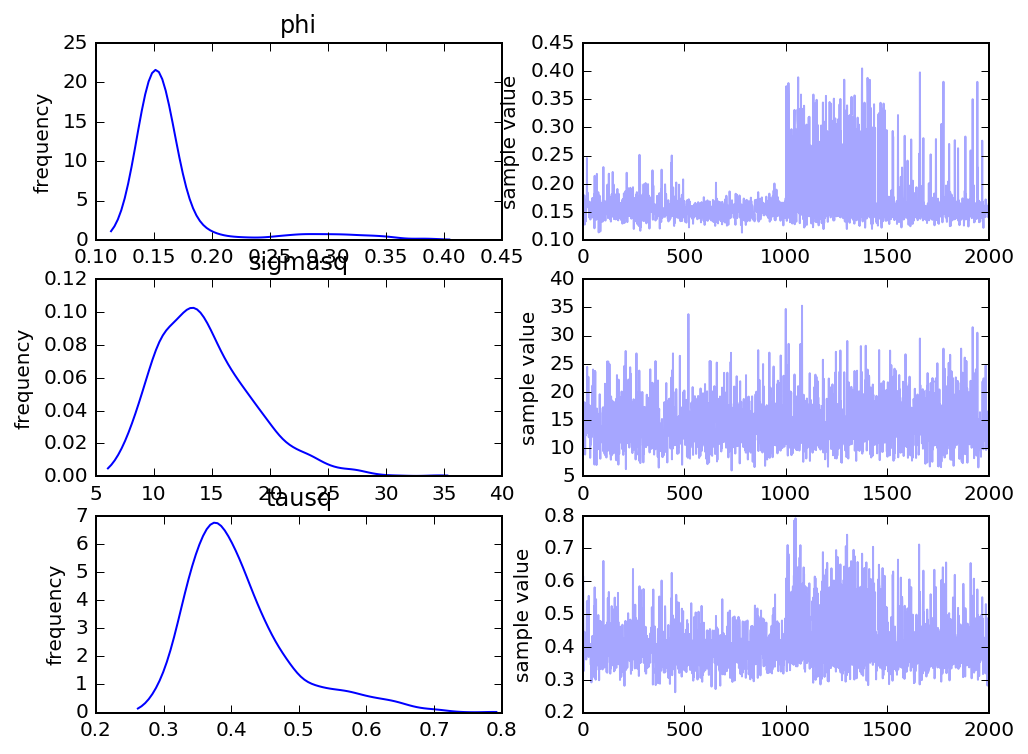

In [12]:
ts_fit.plot(["phi","sigmasq","tausq"]);

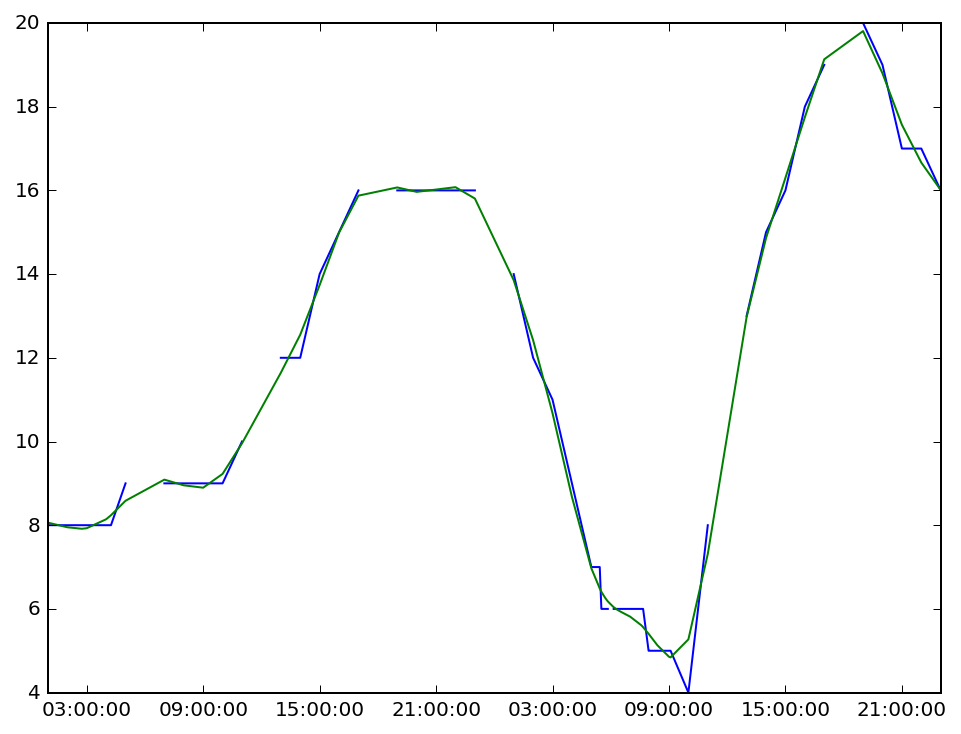

In [13]:
fitted_GP = pd.Series(np.mean(ts_fit.extract("w_s")["w_s"], axis=0), index=twodays.index)
plt.plot(hourly["20150601":"20150602"])
plt.plot(fitted_GP+twodays.mean())

# Spatiotemporal model for 2 stations

## Data prep

In [14]:
# http://www.johndcook.com/blog/python_longitude_latitude/
def distance_on_unit_sphere(lat1, long1, lat2, long2):
 
    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0
         
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
         
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
         
    # Compute spherical distance from spherical coordinates.
         
    # For two locations in spherical coordinates 
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) = 
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length
     
    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) +
           math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )
 
    # Remember to multiply arc by the radius of the earth 
    # in your favorite set of units to get length.
    return arc

In [15]:
isdSubset

,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END
3559,714310,99999,COBOURG (AUT) ONT,CA,NaN,CWNC,43.950,-78.167,78.0,1977,2015
3560,714320,99999,PORT WELLER (AUT) ONT,CA,NaN,CWWZ,43.250,-79.217,79.0,1977,2015
3561,714330,99999,CARIBOU ISLAND (AUT) ONT,CA,NaN,CWCI,47.333,-85.833,187.0,1980,2015
3562,714360,99999,PETERBOROUGH,CA,NaN,CYPQ,44.230,-78.363,191.4,1980,2015


In [16]:
numstations = len(isdSubset)
pairwiseD = np.zeros((numstations, numstations))
for i in range(numstations):
    for j in range(i+1,numstations):
        station1 = isdSubset.iloc[i]
        station2 = isdSubset.iloc[j]
        lat1 = station1["LAT"]
        long1 = station1["LON"]
        lat2 = station2["LAT"]
        long2 = station2["LON"]
        pairwiseD[i,j] = distance_on_unit_sphere(lat1, long1, lat2, long2)
        pairwiseD[j,i] = pairwiseD[i,j]
pairwiseD

array([[ 0.        ,  0.01803816,  0.11054163,  0.00546982],
       [ 0.01803816,  0.        ,  0.10799135,  0.02021158],
       [ 0.11054163,  0.10799135,  0.        ,  0.10576268],
       [ 0.00546982,  0.02021158,  0.10576268,  0.        ]])

In [17]:
hourly_df_ls = []
for istation,stationdata in enumerate(hourly_ls):
    hourly_df_ls.append(pd.DataFrame({
        "station":istation+1, # Stan is 1-indexed
        "temp": stationdata.values}, index=stationdata.index))

hourly_df = pd.concat(hourly_df_ls)
twodays_stmp = hourly_df["20150601":"20150602"].dropna()
stmp_data = {
    "N": len(twodays_stmp),
    "numstations": numstations,
    "time": twodays_stmp.index.values.astype(float) / ns_per_day,
    "temp": twodays_stmp["temp"] - twodays_stmp["temp"].mean(),
    "station": twodays_stmp["station"].values,
    "pairwiseD": pairwiseD,
}

## Inference

In [18]:
spatiotemporal_model = """
    data {
      int<lower=1> N;
      int<lower=1> numstations;
      vector[N] time;
      int<lower=1,upper=numstations> station[N];
      matrix[numstations,numstations] pairwiseD;
      vector[N] temp;
    }

    parameters {
      real<lower=0> sigma;
      // real<lower=0> l_t;
      real<lower=0> l_x;
      real<lower=0> tausq;
      real mu_station[numstations];

      vector[N] w_s;
    }
    transformed parameters {
      vector[N] mu_w;
      for(i in 1:(N)){
          mu_w[i] <- mu_station[station[i]];
      }
      mu_w <- mu_w + sigma*w_s;
    }

    model {
      matrix[N,N] SigmaGP;
      vector[N] mu_zero; 
      for(i in 1:(N)){
          mu_zero[i] <- 0.0;
      }


      // off-diagonal elements
      for(i in 1:(N-1)){
        for(j in (i+1):N){
          real tdiff;
          real xdiff;
          tdiff <- time[i] - time[j];
          xdiff <- pairwiseD[station[i],station[j]];
          // SigmaGP[i,j] <- exp( -pow(tdiff,2)/pow(l_t,2) -pow(xdiff,2)/pow(l_x,2));
          SigmaGP[i,j] <- exp( -pow(tdiff,2)/pow(0.15,2) -pow(xdiff,2)/pow(l_x,2));
          SigmaGP[j,i] <- SigmaGP[i,j];
        }
      }

      // diagonal elements
      for(i in 1:N){
        SigmaGP[i,i] <- 1.01;
      }
      // l_t ~ normal(0,1);
      l_x ~ normal(0,0.1);
      sigma ~ normal(0,5);
      tausq ~ normal(0,1);
      mu_station ~ normal(0,10);

      w_s ~ multi_normal(mu_zero, SigmaGP);  
      temp ~ normal(mu_w, tausq);
    }
"""

In [19]:
stmp_fit = pystan.stan(model_code=spatiotemporal_model, data=stmp_data,
 iter=1000, chains=4)

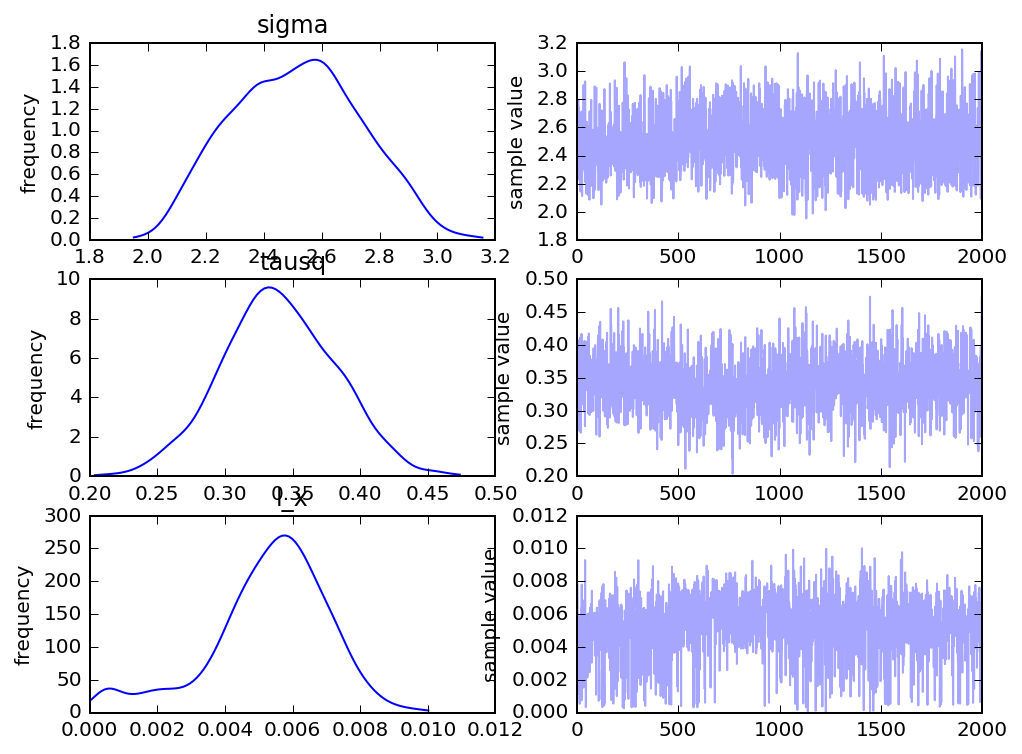

In [20]:
stmp_fit.plot(["sigma","tausq", "l_x"]);

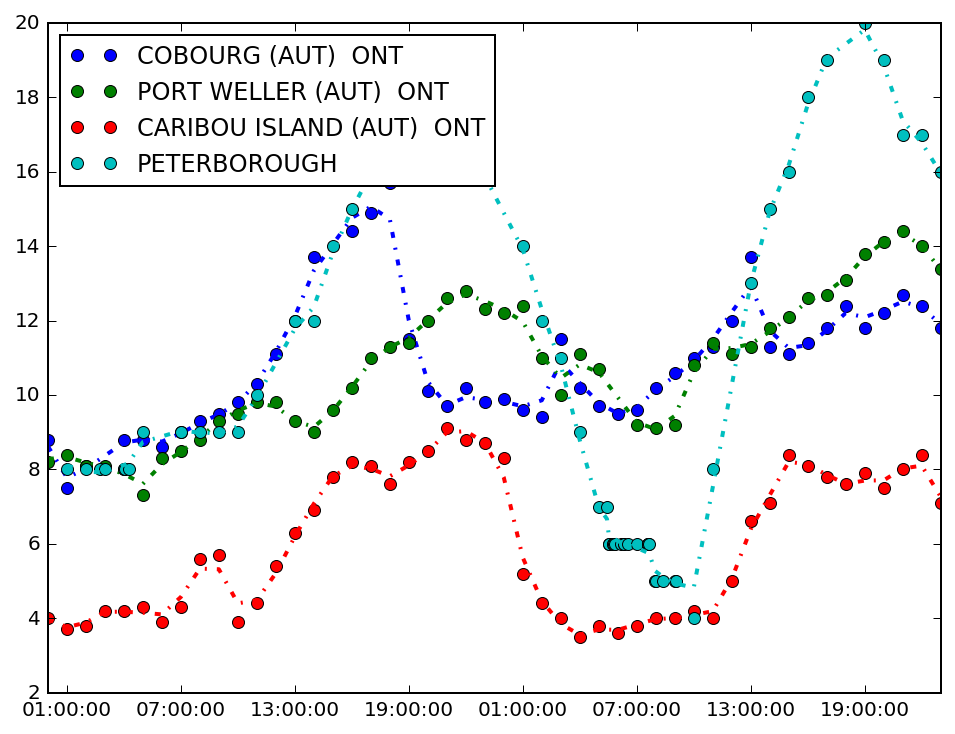

In [21]:
stmp_fitted_GP = pd.Series(np.mean(stmp_fit.extract("mu_w")["mu_w"], axis=0), index=twodays_stmp.index)
for i in range(numstations):
    istat = (twodays_stmp["station"] == i+1).values
    l=plt.plot(twodays_stmp["temp"][istat],"o", label=isdSubset["NAME"].iloc[i])[0]
    plt.plot(stmp_fitted_GP[istat]+twodays_stmp["temp"].mean(), linewidth=2, linestyle="-.", color=l.get_color())
plt.legend(loc="upper left")

# Imputation model

In [22]:
time_min = twodays_stmp.index.min()
time_max = twodays_stmp.index.max()
time_impute = pd.date_range(time_min, time_max, freq="H")

In [34]:
cobourg_df = hourly_df_ls[0]["20150601":"20150602"].dropna()
cutpoints = pd.date_range(time_min.replace(hour=17)-pd.DateOffset(days=1), time_max+pd.DateOffset(days=1), freq="D")

In [35]:
cobourg_df["mday"] = pd.cut(cobourg_df.index.values.astype(float), cutpoints.values.astype(float))

In [36]:
cobourg_Tn = cobourg_df.groupby(by="mday").min()
cobourg_Tx = cobourg_df.groupby(by="mday").max()
n_impt_days = len(cobourg_Tn)
day_TxTn = list(range(1, n_impt_days+1))
iday_impute = pd.cut(time_impute.values.astype(float), cutpoints.values.astype(float)).codes
iday_impute

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2], dtype=int8)

In [166]:
imputation_model = """
functions {
    real softmax(vector x, real k){
        real max10x;
        max10x <- max(k*x);
        return (max10x+log(sum(exp(k*x - max10x))))/k;
    }
    real softmin(vector x, real k){
        return -softmax(-x, k);
    }
}
data {
    int<lower=1> numstations;
    int<lower=1> Ntotal; // Ntrain + Nimpt
    
    // training points (for which we have hourly data)
    int<lower=1> Ntrain;

    vector[Ntrain] time_train;
    int<lower=1,upper=numstations> station_train[Ntrain];
    matrix[numstations,numstations] pairwiseD;
    vector[Ntrain] temp_train;
    
    // Tn Tx data
    int<lower=1> n_impt_stations;
    int<lower=1> N_TxTn; // n_impt_stations * n_impt_days
    int<lower=1> n_impt_days;
    int<lower=1,upper=n_impt_days> day_TxTn[N_TxTn];
    int<lower=1,upper=numstations> station_TxTn[N_TxTn];
    vector[N_TxTn] Tx;
    vector[N_TxTn] Tn;
    
    // imputation points (for which we have )
    int<lower=1> n_impt_times;   
    int<lower=1> Nimpt; // n_impt_stations * n_impt_times
    vector[Nimpt] time_impt;
    int<lower=1,upper=n_impt_days> day_impute[Nimpt];
    int<lower=1,upper=numstations> station_impt[Nimpt];
    
    int<lower=1> impt_times_p_day[N_TxTn];
    
    // hyperparameters
    real<lower=0> sigma;
    real<lower=0> l2_t;
    real<lower=0> l2_x;
    // real<lower=0> l2_h;
    real<lower=0> tausq;
    real<lower=0> k_softmax;
}
transformed data{
    matrix[Ntotal,Ntotal] SigmaGP;
    vector[Ntotal] mu_zero; 
    matrix[Ntotal,Ntotal] SigCholesky;
    for(i in 1:Ntotal){
        mu_zero[i] <- 0.0;
    }

    // == off-diagonal elements ==
    // training data
    for(i in 1:(Ntrain-1)){
        for(j in (i+1):Ntrain){
            real tdiff;
            real xdiff;
            tdiff <- time_train[i] - time_train[j];
            xdiff <- pairwiseD[station_train[i],station_train[j]];
            SigmaGP[i,j] <- exp( -pow(tdiff,2)/l2_t -pow(xdiff,2)/l2_x);
            SigmaGP[j,i] <- SigmaGP[i,j];
        }
    }
    
    // imputation data
    for(i in 1:(Nimpt-1)){
        for(j in (i+1):Nimpt){
            real tdiff;
            real xdiff;
            tdiff <- time_impt[i] - time_impt[j];
            xdiff <- pairwiseD[station_impt[i],station_impt[j]];
            SigmaGP[i+Ntrain,j+Ntrain] <- exp( -pow(tdiff,2)/l2_t -pow(xdiff,2)/l2_x);
            SigmaGP[j+Ntrain,i+Ntrain] <- SigmaGP[i+Ntrain,j+Ntrain];
        }
    }
    
    // correlation between training and impt
    for(i in 1:Ntrain){
        for(j in 1:Nimpt){
            real tdiff;
            real xdiff;
            tdiff <- time_train[i] - time_impt[j];
            xdiff <- pairwiseD[station_train[i],station_impt[j]];
            SigmaGP[i,j+Ntrain] <- exp( -pow(tdiff,2)/l2_t -pow(xdiff,2)/l2_x);
            SigmaGP[j+Ntrain,i] <- SigmaGP[i,j+Ntrain];
        }
    }
    
    // diagonal elements
    for(i in 1:Ntotal){
        SigmaGP[i,i] <- 1.01;
    }
    
    SigCholesky <- cholesky_decompose(SigmaGP);
}
parameters {
    real mu_station[numstations];
    vector[Ntotal] w_std;
    vector[Nimpt] temp_impt;
    real mu;
}
transformed parameters {
    vector[Ntotal] mu_w;
    real Tsoftmax[N_TxTn];
    real Tsoftmin[N_TxTn];
    {
        vector[Ntotal] mu_stn;
        for(i in 1:Ntrain){
            mu_stn[i] <- mu_station[station_train[i]];
        }
        for (i in 1:Nimpt){
            mu_stn[i+Ntrain] <- mu_station[station_impt[i]];
        }
        mu_w <- mu + mu_stn + sigma*(SigCholesky*w_std);
    }   
    {
        int istart;
        istart <- 1;
        for (i in 1:N_TxTn){
            int ntimes;
            ntimes <- impt_times_p_day[i];
            Tsoftmin[i] <- softmin(segment(temp_impt,istart,ntimes), k_softmax);
            Tsoftmax[i] <- softmax(segment(temp_impt,istart,ntimes), k_softmax);
            istart <- istart + ntimes;
        }
    }
}
model {
    mu_station ~ normal(0,10);
    mu ~ normal(0,10);
    w_std ~ normal(0, 1);  
    temp_train ~ normal(mu_w[1:Ntrain], tausq);
    temp_impt ~ normal(mu_w[Ntrain+1:Ntotal], tausq);
    Tn ~ normal(Tsoftmin, 0.1);
    Tx ~ normal(Tsoftmax, 0.1);
}
"""

In [167]:
hourly_train = hourly_df[hourly_df["station"]!=1]["20150601":"20150602"].dropna()

In [168]:
Nimpt = len(time_impute)
Ntrain = len(hourly_train)
impt_data = {
    # == VECTOR LENGTHS ==
    "numstations": numstations,
    "Ntrain": Ntrain,
    "n_impt_times": Nimpt,
    "Nimpt": Nimpt,
    "Ntotal": Nimpt+Ntrain,
    "n_impt_days": n_impt_days,
    "n_impt_stations": 1,
    "N_TxTn": n_impt_days,
    "impt_times_p_day": np.bincount(iday_impute), # won't work with more than 1 station
    # == HOURLY DATA ==
    "time_train": hourly_train.index.values.astype(float) / ns_per_day,
    "station_train": hourly_train["station"],
    "pairwiseD": pairwiseD,
    "temp_train": hourly_train["temp"],
    # == Tn/Tx ==
    "day_TxTn": day_TxTn,
    "station_TxTn": [1]*n_impt_days,
    "Tn": cobourg_Tn["temp"].values,
    "Tx": cobourg_Tx["temp"].values,
    # == IMPUTATION ==
    "time_impt": time_impute.values.astype(float),
    "day_impute": iday_impute+1,
    "station_impt": [1]*len(time_impute),
    # == HYPERPARAMETERS ==
    "sigma": 2.5,
    "tausq": 0.32,
    "l2_x": 0.006**2,
    "l2_t": 0.15**2,
    "k_softmax": 2.0,
}

In [169]:
impt_fit = pystan.stan(model_code=imputation_model, data=impt_data,
 iter=2000, chains=4)

In [170]:
print(impt_fit)

Inference for Stan model: anon_model_3281565c756395d3da54431cfe395c53.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_station[0]    3.9    0.15   4.46  -4.65   0.92   3.95   6.95  12.66    862    1.0
mu_station[1]    2.5    0.15   4.51  -6.13  -0.61   2.52   5.53   11.4    872    1.0
mu_station[2]  -2.21    0.15   4.49 -10.87  -5.27  -2.23    0.8   6.46    862    1.0
mu_station[3]   4.02    0.15   4.52  -4.76   0.97   4.01   7.13  12.72    860    1.0
w_std[0]       -0.95    0.01   0.36  -1.65  -1.19  -0.95  -0.71  -0.26   1031    1.0
w_std[1]       -0.14  9.4e-3   0.34  -0.82  -0.39  -0.14   0.09   0.54   1334    1.0
w_std[2]       -0.73    0.02   0.62  -1.92  -1.14  -0.73  -0.31    0.5   1334    1.0
w_std[3]       -0.49    0.02   0.62  -1.71   -0.9  -0.49  -0.07    0.7   1334    1.0
w_std[4]       -0.47    0.02   0.64  -1.72   -

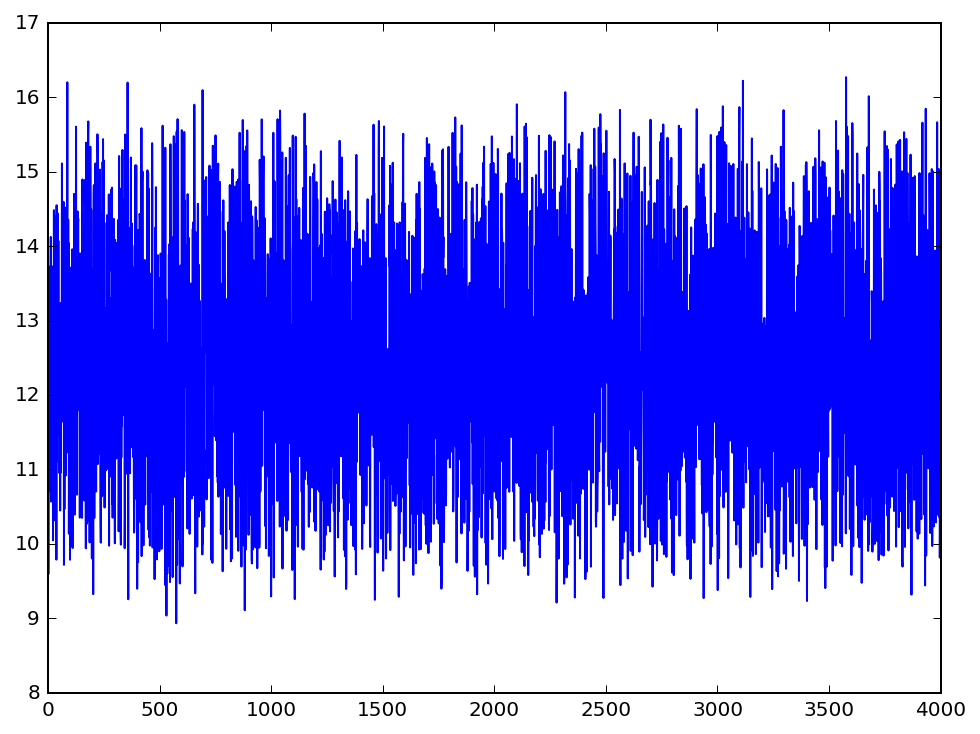

In [171]:
plt.plot(impt_fit.extract("mu_w")["mu_w"][:,-20])

In [172]:
impt_fitted_GP = impt_fit.extract("mu_w")["mu_w"][3000:,:]
imputed_GP = impt_fitted_GP[:,Ntrain:]
imputed_GP_sorted = np.sort(imputed_GP, axis=0)
imputed_0100 = pd.Series(imputed_GP_sorted[100,:], index=time_impute)
imputed_1900 = pd.Series(imputed_GP_sorted[-100,:], index=time_impute)
lower_constraint = pd.Series(cobourg_Tn["temp"].values[iday_impute], index=time_impute)
upper_constraint = pd.Series(cobourg_Tx["temp"].values[iday_impute], index=time_impute)

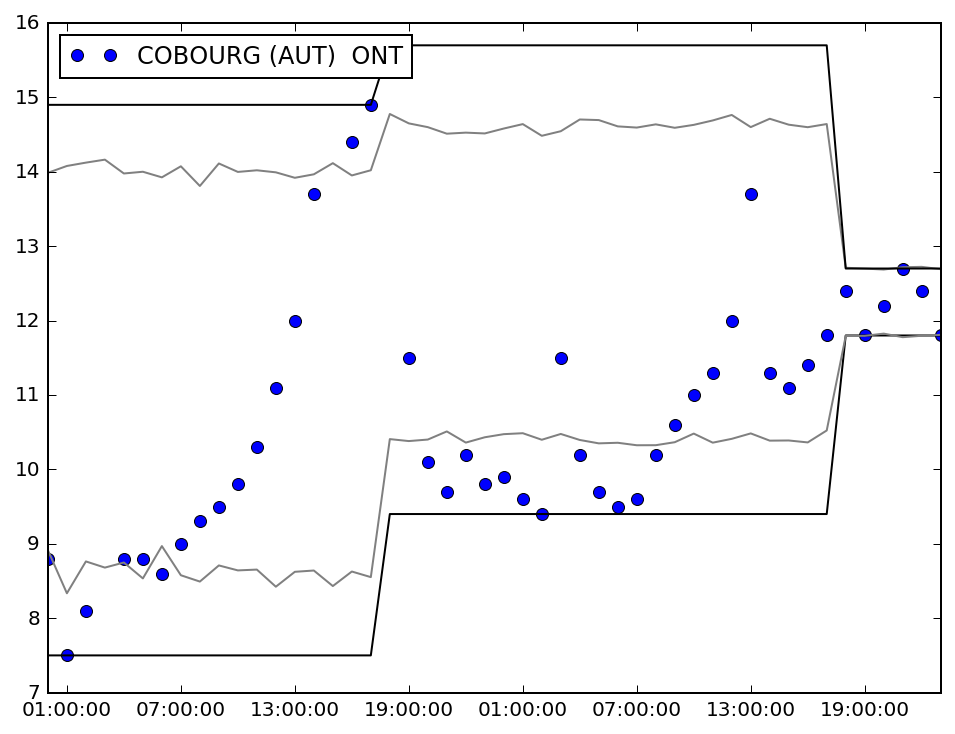

In [173]:
plt.plot(cobourg_df["temp"], "o", label=isdSubset["NAME"].iloc[0])[0]
# for i in range(1,numstations):
#     istat = (hourly_train["station"] == i+1).values
#     l=plt.plot(hourly_train["temp"][istat],"o", label=isdSubset["NAME"].iloc[i])[0]
# #     plt.plot(stmp_fitted_GP[istat]+twodays_stmp["temp"].mean(), linewidth=2, linestyle="-.", color=l.get_color())
plt.plot(lower_constraint, color="black")
plt.plot(imputed_0100, color="grey")
plt.plot(imputed_1900, color="grey")
plt.plot(upper_constraint, color="black")
plt.legend(loc="upper left")
